# Testing multiple basic trading strategies

In [1]:
import pandas as pd
import numpy as np
!pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf

     |████████████████████████████████| 6.3 MB 7.0 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=0140e06f34999f6e0dc9095167c5800e565c996e477799c0154d24f19d574f4b
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
aord = pd.DataFrame(yf.Ticker("^AORD").history("10y"))
nikkei = pd.DataFrame(yf.Ticker("^N225").history("10y"))
hsi = pd.DataFrame(yf.Ticker("HSI").history("10y"))
daxi = pd.DataFrame(yf.Ticker("^GDAXI").history("10y"))
cac40 = pd.DataFrame(yf.Ticker("^FCHI").history("10y"))
sp500 = pd.DataFrame(yf.Ticker("^GSPC").history("10y"))
dji = pd.DataFrame(yf.Ticker("DJI").history("10y"))
nasdaq = pd.DataFrame(yf.Ticker("^IXIC").history("10y"))
spy = pd.DataFrame(yf.Ticker("SPY").history("10y"))

In [4]:
indicepanel=pd.DataFrame(index=spy.index)

In [5]:
indicepanel['spy']=spy['Open'].shift(-1)-spy['Open']
indicepanel['spy_lag1']=indicepanel['spy'].shift(1)
indicepanel['sp500']=sp500["Open"]-sp500['Open'].shift(1)
indicepanel['nasdaq']=nasdaq['Open']-nasdaq['Open'].shift(1)
indicepanel['dji']=dji['Open']-dji['Open'].shift(1)

indicepanel['cac40']=cac40['Open']-cac40['Open'].shift(1)
indicepanel['daxi']=daxi['Open']-daxi['Open'].shift(1)

indicepanel['aord']=aord['Close']-aord['Open']
indicepanel['hsi']=hsi['Close']-hsi['Open']
indicepanel['nikkei']=nikkei['Close']-nikkei['Open']

In [6]:
# We use  'fillna()' to forward filling the Nan values
# Then we drop the reminding Nan values
indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()

In [7]:
indicepanel.isnull().sum()

spy         0
spy_lag1    0
sp500       0
nasdaq      0
dji         0
cac40       0
daxi        0
aord        0
hsi         0
nikkei      0
dtype: int64

In [8]:
indicepanel.shape

(2516, 10)

## Multiple Linear Regression

#### Splitting data :

In [9]:
Train = indicepanel.iloc[-2000:-1000, :]
Test = indicepanel.iloc[-1000:, :]
print(Train.shape, Test.shape)

(1000, 10) (1000, 10)


#### Checking correlations : 

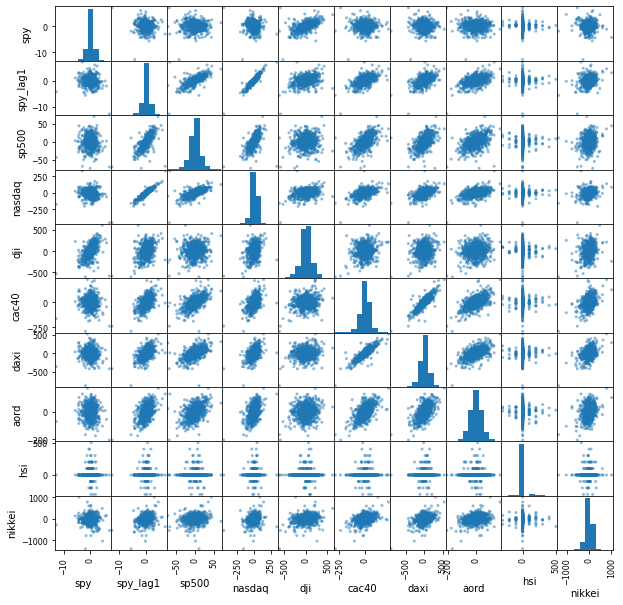

In [10]:
from pandas.plotting import scatter_matrix
sm = scatter_matrix(Train, figsize=(10, 10))

In [11]:
# Find the indice with largest correlation
corr_array = Train.iloc[:, :-1].corr()['spy'].sort_values()
print(corr_array)

spy_lag1   -0.073953
nasdaq     -0.065315
cac40      -0.043211
daxi       -0.033882
hsi        -0.025268
sp500      -0.021835
aord       -0.006384
dji         0.561207
spy         1.000000
Name: spy, dtype: float64


#### Training model and predictions :

In [12]:
formula = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=Train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     92.01
Date:                Sat, 14 Aug 2021   Prob (F-statistic):          3.24e-124
Time:                        14:41:23   Log-Likelihood:                -1442.1
No. Observations:                1000   AIC:                             2904.
Df Residuals:                     990   BIC:                             2953.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0481      0.033      1.467      0.143      -0.016       0.112
spy_lag1      -0.6370      0.073     -8.774      0.000      -0.780      -0.495
sp500          0.0303      0.004      8.325      0.000       0.023       0.037
nasdaq         0.0034      0.002      1.788      0.074      -0.000       0.007
dji            0.0079      0.000     28.451      0.000       0.007       0.008
cac40         -0.0029      0.001     -2.023      0.043      -0.006   -8.83e-05
aord           0.0011      0.001      1.141      0.254      -0.001       0.003
daxi           0.0009      0.001      1.538      0.124      -0.000       0.002
nikkei        -0.0009      0.000     -4.084      0.000      -0.001      -0.000
hsi           -0.0003      0.001     -0.429      0.668      -0.002       0.001
==============================================================================
Omnibus:                      339.054   Durbin-Watson:                   2.218
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7124.502
Skew:                          -1.026   Prob(JB):                         0.00
Kurtosis:                      15.914   Cond. No.                         417.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)

In [14]:
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'])**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE

def assessTable(test, train, model, model_k, yname):
  r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
  r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
  assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
  assessment['Train'] = [r2train, RMSEtrain]
  assessment['Test'] = [r2test, RMSEtest]
  return assessment

In [15]:
assessTable(Test, Train, lm, 9, 'spy')

,Train,Test
R2,0.450523,0.594016
RMSE,1.028622,3.560277


In [16]:
Test['Order'] = [1 if sig>0 else -1 for sig in Train['PredictedY']]
Test['Profit'] = Test['spy'] * Test['Order']

Test['Wealth'] = Test['Profit'].cumsum()
print('Total profit made in Test: ', Test['Profit'].sum())

Total profit made in Test:  -49.61672233975517


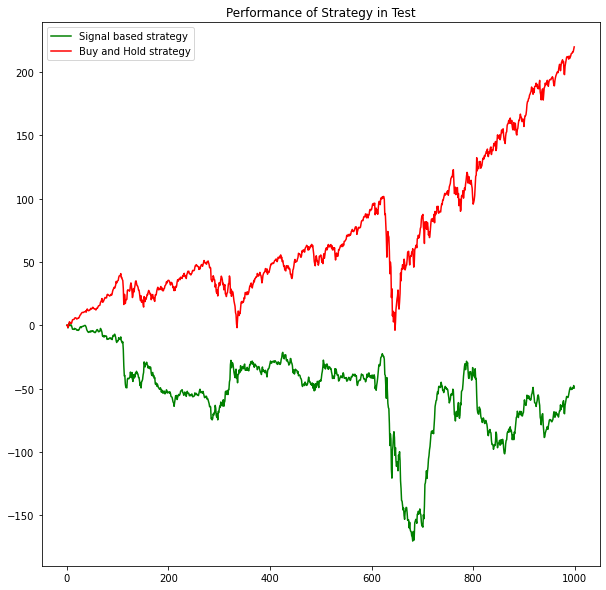

In [17]:
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Test')
plt.plot(Test['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Test['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

# XGBOOST

In [19]:
from sklearn.model_selection import train_test_split
y=indicepanel.spy
X=indicepanel.drop("spy", axis=1)
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.5)

In [20]:
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model.fit(X_train, y_train)

[14:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [21]:
preds = my_model.predict(X_test)

In [22]:
import sklearn.metrics as skm

print("mean_absolute_error = ",skm.mean_absolute_error(y_test,preds))
print("mean_squared_error = ",skm.mean_squared_error(y_test,preds))
print("r2 = ",skm.r2_score(y_test,preds))

mean_absolute_error =  1.369273589024394
mean_squared_error =  5.923307025149337
r2 =  -0.08917066003533902


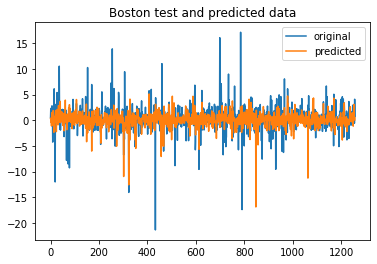

In [23]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, preds, label="predicted")
plt.title("Boston test and predicted data")
plt.legend()
plt.show()


In [24]:
res_xgb=pd.DataFrame()
y_test_values=y_test[1]
res_xgb["predictions"]=preds
res_xgb["Order"]=[1 if sig>0 else -1 for sig in res_xgb.predictions]
res_xgb['Profit'] = y_test.values * res_xgb.Order
res_xgb["Wealth"] = res_xgb.Profit.cumsum()
print('Total profit made in Test: ', res_xgb['Profit'].sum())

Total profit made in Test:  570.1709883021194


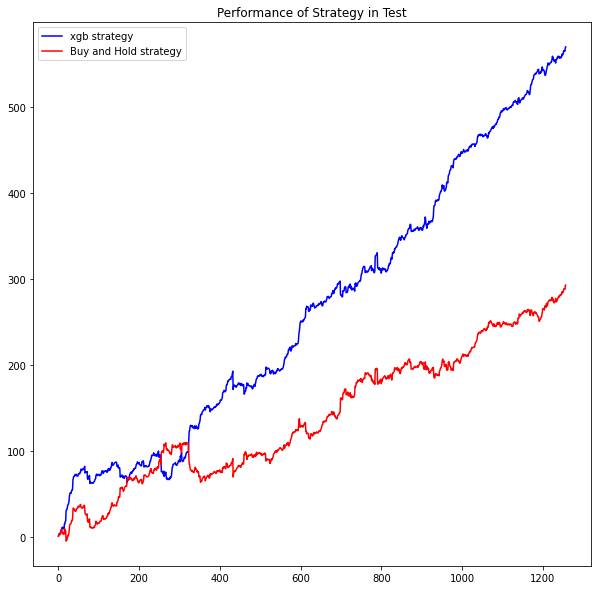

In [25]:
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Test')
plt.plot(res_xgb['Wealth'].values, color='blue', label='xgb strategy')
plt.plot(y_test.cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
